In [340]:
import csv
import numpy as np
import math
import scipy.optimize as optimize

In [341]:
A = []
with open('data_logsumexp_A.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        row = [float(x) for x in row]
        # print(row)
        A.append(row)
A = np.array(A)
A.shape

(300, 100)

In [342]:
B = []
with open('data_logsumexp_B.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        B.append([float(x) for x in row])
B = np.array(B)
B.shape

(300, 1)

In [343]:
def f(x):
    return np.log(np.sum(np.exp((A @ x) + B)))

In [344]:
def f_diff1(x):
    results = np.empty_like(x)
    for i in range(A.shape[1]):
        a = A[:,i]
        result = np.exp((A @ x) + B).reshape(A.shape[0],)
        result = (1/np.sum(np.exp((A @ x) + B))) * np.dot(result,a)
        results[i] = [result]
    return results

In [345]:
def steepest_descent(x0,t=0.1,k=200):
    x_hist = [x0]
    for i in range(k):
        if i == 0:
            x_prev = x0
        else:
            x_prev = x_hist[i-1]
        x_prev_delta = -1 * f_diff1(x_prev)
        x_hist.append(x_prev + (t * x_prev_delta))
    return [f(x) for x in x_hist]

In [346]:
# FISTA
def fista(x0, t = 0.1, k = 200):
    x_hist = [x0]
    gamma_curr = 1
    y_next = x0
    for i in range(k):
        x = y_next - (t*f_diff1(y_next))
        gamma_next = (1 + math.sqrt(1 + (4*(math.pow(gamma_curr,2)))))/2
        y_next = x + (((gamma_curr - 1)/gamma_next)*(x - x_hist[-1]))
        x_hist.append(x)
    return [f(x) for x in x_hist]

In [347]:
def custmin(fun, x0, args=(), maxfev=None, stepsize=0.1,
         maxiter=5000, callback=None, **options):
    bestx = x0
    besty = fun(x0)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        improved = False
        niter += 1
        for dim in range(np.size(x0)):
            for s in [bestx[dim] - stepsize, bestx[dim] + stepsize]:
                testx = np.copy(bestx)
                testx[dim] = s
                testy = fun(testx, *args)
                funcalls += 1
                if testy < besty:
                    besty = testy
                    bestx = testx
                    improved = True
            if callback is not None:
                callback(bestx)
            if maxfev is not None and funcalls >= maxfev:
                stop = True
                break

    return optimize.OptimizeResult(fun=besty, x=bestx, nit=niter,
                           nfev=funcalls, success=(niter > 1))

In [370]:
# intital
t = 0.1
max_interations = 500
# x is in R^n
n = 100
x0 = np.zeros((n,1))
x0 = np.random.rand(n,1)*2
# x0 = np.array([1]*n).reshape(n,1)

In [371]:
result = optimize.minimize(f, x0, method=custmin, options=dict(stepsize=0.01))
f_opt = None
x_opt = None
if result.success:
    f_opt = result.fun
    x_opt = result.x
    print('f_opt:',f_opt)
else:
    raise ValueError(result.message)

f_opt: 5.61137560644434


In [372]:
f_hist_SD = steepest_descent(x0,t,max_interations)
print('minimize f(x) try from fixed t, k value:',min(f_hist_SD))
if min(f_hist_SD) < f_opt:
    f_opt = min(f_hist_SD)

minimize f(x) try from fixed t, k value: 5.616394749983161


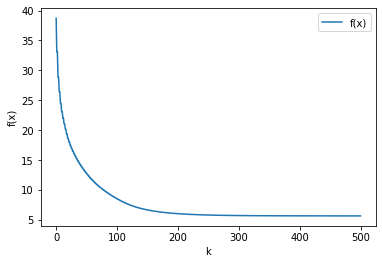

In [373]:
import matplotlib.pyplot as plt
plt.plot([x for x in range(len(f_hist_SD))], f_hist_SD, label='f(x)')
plt.xlabel("k")
plt.ylabel("f(x)")
plt.legend(loc='upper right')
plt.show()

In [374]:
f_hist_FISTA = fista(x0,t,max_interations)
print('minimize f(x) try from fixed t, k value:',min(f_hist_FISTA))
if min(f_hist_FISTA) < f_opt:
    f_opt = min(f_hist_FISTA)

minimize f(x) try from fixed t, k value: 5.61093023206604


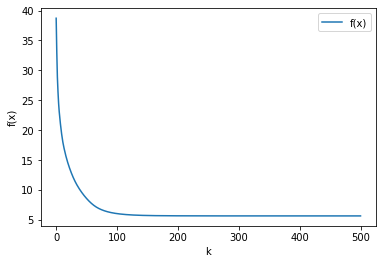

In [375]:
import matplotlib.pyplot as plt
plt.plot([x for x in range(len(f_hist_FISTA))], f_hist_FISTA, label='f(x)')
plt.xlabel("k")
plt.ylabel("f(x)")
plt.legend(loc='upper right')
plt.show()

In [376]:
f_err_SD = [abs(f_curr - f_opt)/abs(f_opt) for f_curr in f_hist_SD]
f_err_FISTA = [abs(f_curr - f_opt)/abs(f_opt) for f_curr in f_hist_FISTA]

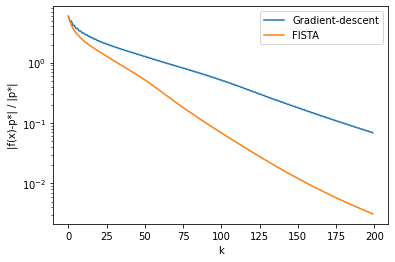

In [379]:
import matplotlib.pyplot as plt
plt.plot([x for x in range(200)], f_err_SD[:200], label='Gradient-descent')
plt.plot([x for x in range(200)], f_err_FISTA[:200], label='FISTA')
plt.yscale('log')
plt.xlabel("k")
plt.ylabel("|f(x)-p*| / |p*|")
plt.legend(loc='upper right')
plt.show()